# 구내식당 식사인원 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 사용자 운영체제 확인
import os
os.name

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# Dataset

In [3]:
train = pd.read_csv("./data/weather_corona_train.csv", encoding='cp949')
test = pd.read_csv("./data/weather_corona_test.csv", encoding='cp949')

train = train.iloc[:,1:]
test = test.iloc[:,1:]

In [4]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,평균기온(°C),일강수량(mm),평균 지면온도(°C),확진자수
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,-0.6,NaN,2.3,0
1,2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,-2.3,NaN,1.2,0
2,2016-02-03,수,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,-1.7,NaN,1.3,0
3,2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,-0.2,NaN,1.0,0
4,2016-02-05,금,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,1.3,NaN,2.4,0


# 전처리 및 EDA

## EDA

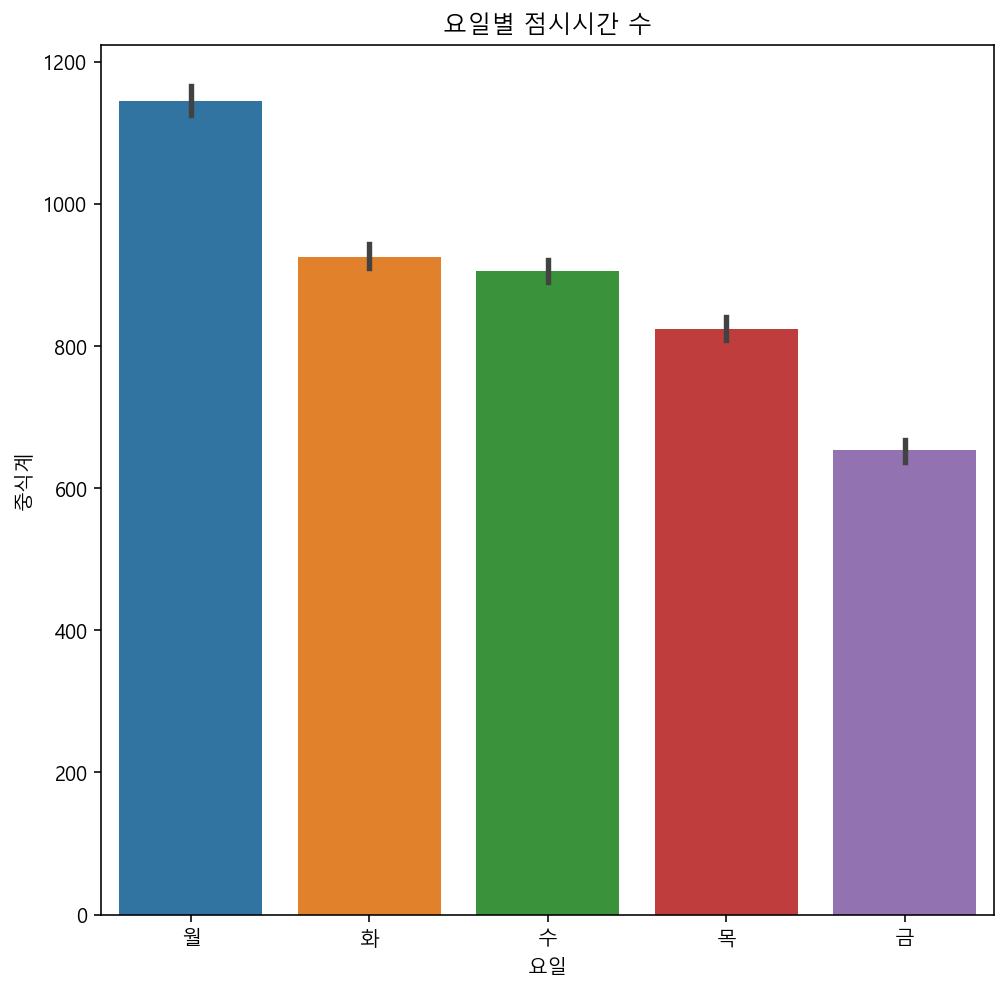

In [5]:
plt.figure(figsize=(8,8))


sns.barplot(x="요일", y="중식계", data=train)
plt.title("요일별 점시시간 수")
plt.show()

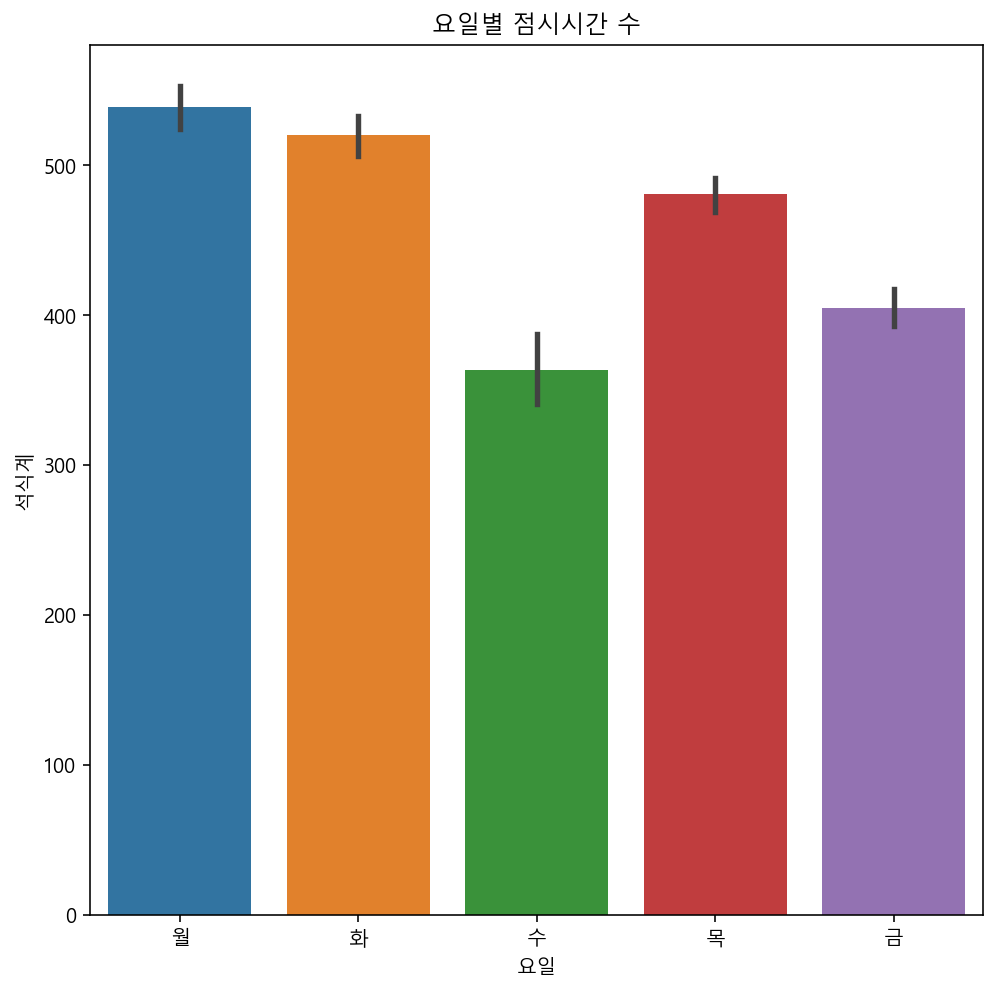

In [6]:
plt.figure(figsize=(8,8))


sns.barplot(x="요일", y="석식계", data=train)
plt.title("요일별 점시시간 수")
plt.show()

## 날씨

In [7]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '평균기온(°C)',
       '일강수량(mm)', '평균 지면온도(°C)', '확진자수'],
      dtype='object')

In [8]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,평균기온(°C),일강수량(mm),평균 지면온도(°C),확진자수
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,-0.6,NaN,2.3,0
1,2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,-2.3,NaN,1.2,0
2,2016-02-03,수,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,-1.7,NaN,1.3,0
3,2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,-0.2,NaN,1.0,0
4,2016-02-05,금,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,1.3,NaN,2.4,0


In [9]:
train.drop(['평균 지면온도(°C)'], axis=1, inplace=True)
test.drop(['평균 지면온도(°C)'], axis=1, inplace=True)

### Null

In [10]:
print('train\n', train.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum(), '\n')
print('test\n', test.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum())

train
 평균기온(°C)      1
일강수량(mm)    819
dtype: int64 

test
 평균기온(°C)     0
일강수량(mm)    38
dtype: int64


In [12]:
train['평균기온(°C)'].fillna(method='ffill', inplace=True)

In [13]:
train['일강수량(mm)'].fillna(0, inplace=True)
test['일강수량(mm)'].fillna(0, inplace=True)

In [14]:
print('train\n', train.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum(), '\n')
print('test\n', test.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum())

train
 평균기온(°C)    0
일강수량(mm)    0
dtype: int64 

test
 평균기온(°C)    0
일강수량(mm)    0
dtype: int64


### 강수량

In [16]:
train['일강수량'] = np.where(train.loc[:,'일강수량(mm)']==0, 0, 1)

In [19]:
train['일강수량'].value_counts()

0    896
1    309
Name: 일강수량, dtype: int64

## 확진자수

In [ ]:
train['확진자수'].isnull().sum()

In [ ]:
test['확진자수'].isnull().sum()

## 휴일 & 공휴일 전 후

In [ ]:
holiday_list = [] 
for i in range(2016,2022):
    for date in holidays.KR(years=i).keys():  # 한국 공휴일 가져오기
        holiday_list.append(date)

In [ ]:
holiday_before_list=[]
for_mat='%Y-%m-%d'
for i in holiday_list:
    holiday_before_list.append((i - timedelta(days=1)).strftime(for_mat))
        # i - timedelta(days=1): datetime에서 날짜 하루 빼기
        # .strftime(for_mat): 포맷과 같은 형식으로 datetime에서 str로 변환

In [ ]:
def holiday_before(x):
    if x in holiday_before_list:
        return 1
    else:
        return 0
train['공휴일전'] = train.일자.apply(holiday_before)
test['공휴일전'] = test.일자.apply(holiday_before)

In [ ]:
holiday_after_list=[]
for_mat='%Y-%m-%d'
for i in holiday_list:
    holiday_after_list.append((i + timedelta(days=1)).strftime(for_mat))

In [ ]:
def holiday_after(x):
    if x in holiday_after_list:
        return 1
    else:
        return 0
train['공휴일후'] = train.일자.apply(holiday_after)
test['공휴일후'] = test.일자.apply(holiday_after)

In [ ]:
## 누락된 것은 찾아서 넣음

# 16-4-13 국회의원 선거
train['공휴일전'][47]=1
train['공휴일후'][48]=1

# 17-5-9 대통령 선거
train['공휴일전'][311]=1
train['공휴일후'][312]=1

# 18-6-13 지방선거
train['공휴일전'][579]=1
train['공휴일후'][580]=1

# 20-4-15 국회의원 선거
train['공휴일전'][1027]=1
train['공휴일후'][1028]=1

# 20-9-30 추석
train['공휴일전'][1129]=1

In [ ]:
train.공휴일전.value_counts()

In [ ]:
train.공휴일후.value_counts()

In [ ]:
train.loc[:,['공휴일전', '공휴일후']].sum()

In [ ]:
test.loc[:,['공휴일전', '공휴일후']].sum()

## 파생변수

In [ ]:
train.일자 = train.일자.astype('datetime64')
test.일자 = test.일자.astype('datetime64')

In [ ]:
train['월'] = train.일자.dt.month
train['일'] = train.일자.dt.day
train['년'] = train.일자.dt.year

test['월'] = test.일자.dt.month
test['일'] = test.일자.dt.day
test['년'] = test.일자.dt.year

In [ ]:
train['식사가능자수'] = train['본사정원수'] - train['본사출장자수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사출장자수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

# train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
# test['휴가비율'] = test['본사휴가자수']/test['본사정원수']

# train['출장비율'] = train['본사출장자수']/train['본사정원수']
# test['출장비율'] = test['본사출장자수']/test['본사정원수']

train['야근비율'] = train['본사시간외근무명령서승인건수']/train['식사가능자수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['식사가능자수']

# train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']
# test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

In [ ]:
train.loc[train.중식계==0,['일자','요일','석식메뉴']]
# 중식 = 0 인 날 없음

In [ ]:
train.loc[train.석식계==0,['일자','요일','석식메뉴']]
# 마지막주(4주차도 있고 5주차도 있는거보면 애매) 수요일
# 17-9-29: 추석 전 금요일
# 18-2-14: 설날 전 수요일
# 18-9-19: 다음주 수요일이 추석이라서 마지막주 수요일이긴 함
# 19-12-31: 마지막주 수요일이 성탄절, 다음날이 설날이라서 이때 안하는듯

In [ ]:
# test : 메뉴가 비워져있는 경우는 없음 -> 공휴일이 존재하긴함
test.loc[:,['일자','요일','석식메뉴']]

## 메뉴정리

In [ ]:
train.columns

### 중식

#### split

In [ ]:
def split_menu(x):
  menu_return = []  #return할 메뉴 데이터. 메뉴 스플릿 & 원산지 제외
  for data in x:
    menus = []              #전처리된 메뉴
    menus_sp = data.split() #띄어쓰기 split
    for menu_sp in menus_sp:
      if '(' in menu_sp:
        pass
      elif ',' in menu_sp:  #comma split
        menus_comma = menu_sp.split(',')
        for menu_comma in menus_comma:
          menus.append(menu_comma)
      else:
        menus.append(menu_sp)
    menu_return.append(menus)
  return menu_return

In [ ]:
train['중식메뉴리스트'] = split_menu(train['중식메뉴'])

#### 메뉴 종류별 구분


In [ ]:
# 위에서 언급한 메인, 국, 반찬만 나누어주기
lunch_menu = train['중식메뉴리스트']

bob=[]
soup=[]
main=[]

for i in range(len(train)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [ ]:
#누락이 있으면 안되므로 확인해주자

print(len(bob))
print(len(soup))
print(len(main))
print('--')
print(len(train))

In [ ]:
bob

In [ ]:
temp = []
for b in bob:
    if b.split('/')[0] == "쌀밥":
        temp.append("쌀밥")
    else:
        temp.append(b)
        
bob = temp

In [ ]:
#확인후에 추가
train['bob_l'] = bob
train['soup_l'] = soup
train['main_l'] = main

In [ ]:
train['bob_l'].value_counts()

In [ ]:
train['soup_l'].value_counts()

In [ ]:
train['main_l'].value_counts()

In [ ]:
train.head()

### 석식

#### split

In [ ]:
train['석식메뉴리스트'] = split_menu(train['석식메뉴'])

#### 메뉴 종류별 구분

In [ ]:
dinner_menu = train['석식메뉴리스트']

bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:
    
    
    if len(word) == 0:
        bobd.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        soupd.append('None')
        maind.append('None')
    elif '*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의달' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기계발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '*자기계발의날*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기개발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')

    else:
        bobd.append(word[0])
        soupd.append(word[1])
        maind.append(word[2])

In [ ]:
#다들어왔는지 확인
print(len(dinner_menu))
print(len(bobd))
print(len(soupd))
print(len(maind))

In [ ]:
temp = []
for b in bobd:
    if b.split('/')[0] == "쌀밥":
        temp.append("쌀밥")
    else:
        temp.append(b)
        
bobd = temp

In [ ]:
train['bob_d'] = bobd
train['soup_d'] = soupd
train['main_d'] = maind

In [ ]:
train['bob_d'].value_counts()

In [ ]:
train['soup_d'].value_counts()

In [ ]:
train['main_d'].value_counts()

## test

In [ ]:
test['중식메뉴리스트'] = split_menu(test['중식메뉴'])
test['석식메뉴리스트'] = split_menu(test['석식메뉴'])

In [ ]:
# 위에서 언급한 메인, 국, 반찬만 나누어주기
lunch_menu = test['중식메뉴리스트']

bob=[]
soup=[]
main=[]

for i in range(len(test)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [ ]:
#누락이 있으면 안되므로 확인해주자

print(len(bob))
print(len(soup))
print(len(main))
print('--')
print(len(test))

In [ ]:
temp = []
for b in bob:
    if b.split('/')[0] == "쌀밥":
        temp.append("쌀밥")
    else:
        temp.append(b)
        
bob = temp

In [ ]:
#확인후에 추가
test['bob_l'] = bob
test['soup_l'] = soup
test['main_l'] = main

In [ ]:
test.head()

In [ ]:
dinner_menu = test['석식메뉴리스트']

bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:

    bobd.append(word[0])
    soupd.append(word[1])
    maind.append(word[2])

In [ ]:
#다들어왔는지 확인
print(len(dinner_menu))
print(len(bobd))
print(len(soupd))
print('-'*10)
print(len(maind))

In [ ]:
temp = []
for b in bobd:
    if b.split('/')[0] == "쌀밥":
        temp.append("쌀밥")
    else:
        temp.append(b)
        
bobd = temp

In [ ]:
test['bob_d'] = bobd
test['soup_d'] = soupd
test['main_d'] = maind

In [ ]:
test.head()

## Encoding

In [ ]:
train.columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(pd.concat([train['bob_l'],test['bob_l']]).unique())
train['bob_l']  = le.transform(train['bob_l'])

test['bob_l'] = le.transform(test['bob_l'])

In [ ]:
le = LabelEncoder()
le.fit(pd.concat([train['soup_l'],test['soup_l']]).unique())
train['soup_l']  = le.transform(train['soup_l'])

test['soup_l'] = le.transform(test['soup_l'])

In [ ]:
le = LabelEncoder()
le.fit(pd.concat([train['main_l'],test['main_l']]).unique())
train['main_l']  = le.transform(train['main_l'])

test['main_l'] = le.transform(test['main_l'])

In [ ]:
le = LabelEncoder()
le.fit(pd.concat([train['bob_d'],test['bob_d']]).unique())
train['bob_d']  = le.transform(train['bob_d'])

test['bob_d'] = le.transform(test['bob_d'])

In [ ]:
le = LabelEncoder()
le.fit(pd.concat([train['soup_d'],test['soup_d']]).unique())
train['soup_d']  = le.transform(train['soup_d'])

test['soup_d'] = le.transform(test['soup_d'])

In [ ]:
le = LabelEncoder()
le.fit(pd.concat([train['main_d'],test['main_d']]).unique())
train['main_d']  = le.transform(train['main_d'])

test['main_d'] = le.transform(test['main_d'])

# 모델링

In [ ]:
print('train shape : {}'.format(train.shape))
print('test shape : {}'.format(test.shape))

In [ ]:
from pycaret.regression import *

In [ ]:
train.columns

In [ ]:
test.columns

In [ ]:
train_ln = train[['중식계','요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수','현본사소속재택근무자수',
                  '평균기온(°C)', '일강수량(mm)', '확진자수', '공휴일전', '공휴일후', '월', '일', '년', '식사가능자수', '야근비율','bob_l', 'soup_l', 'main_l']]
train_din = train[['석식계','요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수','현본사소속재택근무자수',
                   '평균기온(°C)', '일강수량(mm)', '확진자수', '공휴일전', '공휴일후', '월', '일', '년', '식사가능자수', '야근비율','bob_d', 'soup_d', 'main_d']]

test_ln = test[['요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수','현본사소속재택근무자수',
                '평균기온(°C)', '일강수량(mm)', '확진자수', '공휴일전', '공휴일후', '월', '일', '년', '식사가능자수', '야근비율','bob_l', 'soup_l', 'main_l']]
test_din = test[['요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수','현본사소속재택근무자수',
                 '평균기온(°C)', '일강수량(mm)', '확진자수', '공휴일전', '공휴일후', '월', '일', '년', '식사가능자수', '야근비율','bob_d', 'soup_d', 'main_d']]

## 중식계

In [ ]:
# 분석 환경 만들기 (setup)
s = setup(train_ln, target='중식계')

In [ ]:
# 모델 비교
best = compare_models(sort='MAE')

In [ ]:
# 모델 생성
et = create_model('et', cross_validation = False)
gbr = create_model('gbr', cross_validation = False)
lgbm = create_model('lightgbm', cross_validation = False)
rf = create_model('rf', cross_validation = False)

In [ ]:
# 모델 하이퍼파라미터 튜닝
tuned_et = tune_model(et, optimize='MAE', n_iter=10)
tuned_gbr = tune_model(gbr, optimize='MAE', n_iter=10)
tuned_lgbm = tune_model(lgbm, optimize='MAE', n_iter=10)
tuned_rf = tune_model(rf, optimize='MAE', n_iter=10)

In [ ]:
# 모델 블렌딩
blender_specific = blend_models(estimator_list = [tuned_et,tuned_gbr,tuned_lgbm, tuned_rf],
                                optimize = 'MAE')

In [ ]:
# 학습 및 예측
# 마지막 학습(Finalize)
final_model = finalize_model(blender_specific)

# 예측(Predict)
pred_ln = predict_model(final_model, data = test_ln)

## 석식계

In [ ]:
# 분석 환경 만들기 (setup)
s = setup(train_din, target='석식계')

In [ ]:
# 모델 비교
best = compare_models(sort='MAE')

In [ ]:
# 모델 생성
et = create_model('et', cross_validation = False)
gbr = create_model('gbr', cross_validation = False)
lgbm = create_model('lightgbm', cross_validation = False)
rf = create_model('rf', cross_validation = False)

In [ ]:
# 모델 하이퍼파라미터 튜닝
tuned_et = tune_model(et, optimize='MAE', n_iter=10)
tuned_gbr = tune_model(gbr, optimize='MAE', n_iter=10)
tuned_lgbm = tune_model(lgbm, optimize='MAE', n_iter=10)
tuned_rf = tune_model(rf, optimize='MAE', n_iter=10)

In [ ]:
# 모델 블렌딩
blender_specific = blend_models(estimator_list = [tuned_et,tuned_gbr,tuned_lgbm, tuned_rf],
                                optimize = 'MAE')

In [ ]:
# 학습 및 예측
# 마지막 학습(Finalize)
final_model = finalize_model(blender_specific)

# 예측(Predict)
pred_din = predict_model(final_model, data = test_din)

# Submission

In [ ]:
submission = pd.read_csv("./data/sample_submission.csv")

In [ ]:
submission['중식계'] = pred_ln['Label']
submission['석식계'] = pred_din['Label']

In [ ]:
submission.to_csv("./data/submission_pycaret.csv",index=False)